In [ ]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

In [ ]:
# Set device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Set transforms to image
transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

In [ ]:
# Download Dataset and apply transform
path = "./"
train_ds = torchvision.datasets.MNIST(root=path, train=True, download=True, transform=transform)
test_ds = torchvision.datasets.MNIST(root=path, train=False, transform=transform, download=True)

In [ ]:
len(train_ds)

60000

In [ ]:
img, label = train_ds[0]
img.squeeze().numpy().shape, label

((28, 28), 5)

In [ ]:
import random

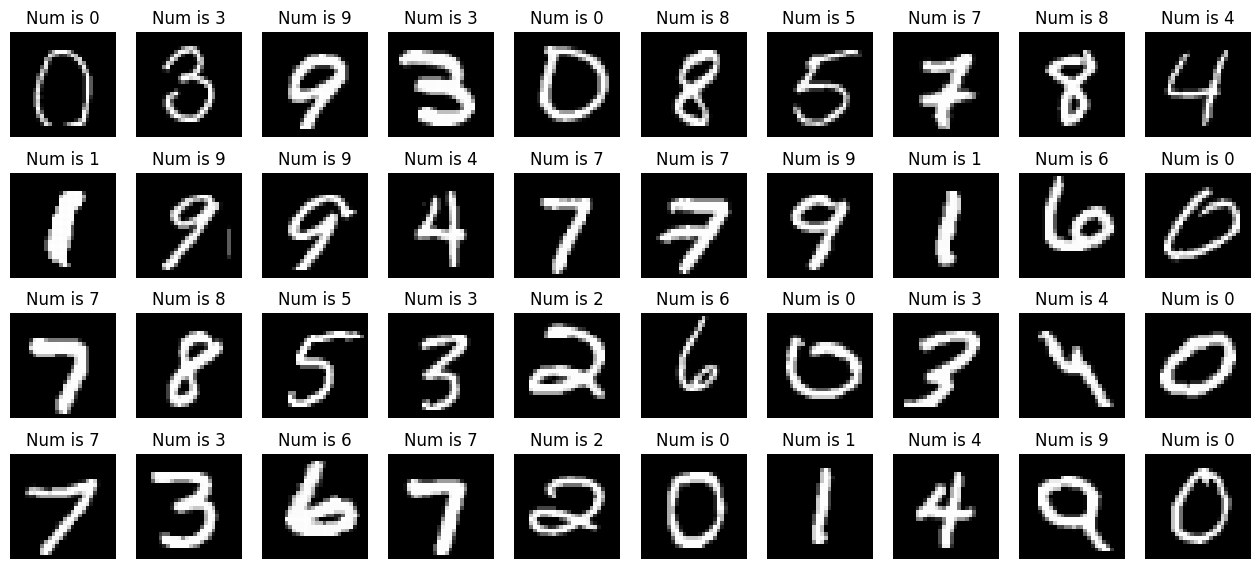

In [ ]:
# Visualize some examples
rows, cols = 4, 10
fig = plt.figure(figsize=(16, 7))
for i in range(1, rows*cols+1):
    random_idx = random.randint(0, len(train_ds))
    fig.add_subplot(rows, cols, i)
    img, label = train_ds[random_idx]
    img = img.squeeze().numpy()
    plt.imshow(img, cmap="gray")
    plt.title(f"Num is {label}")
    plt.axis(False)

In [ ]:
# Build train and evaluation pipeline
val_ds = Subset(train_ds, torch.arange(10000))
train_ds = Subset(train_ds, torch.arange(10000, len(train_ds)))

In [ ]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)

In [ ]:
# Building model
model = nn.Sequential()
model.add_module("conv1", nn.Conv2d(in_channels=1, out_channels=32, padding=2, kernel_size=3))
model.add_module("relu1", nn.ReLU())
model.add_module("pool1", nn.AvgPool2d(kernel_size=2))
model.add_module("conv2", nn.Conv2d(in_channels=32, out_channels=64, padding=2, kernel_size=5))
model.add_module("relu2", nn.ReLU())
model.add_module("pool2", nn.AvgPool2d(kernel_size=2))

In [ ]:
sample = torch.ones((32, 1, 28, 28))
model(sample).shape

torch.Size([32, 64, 7, 7])

In [ ]:
model.add_module("flatten", nn.Flatten())
sample = torch.ones((32, 1, 28, 28))
model(sample).shape

torch.Size([32, 3136])

In [ ]:
model.add_module("fc1", nn.Linear(3136, 1024))
model.add_module("relu3", nn.ReLU())
model.add_module("drop", nn.Dropout(p=0.5))
model.add_module("fc2", nn.Linear(1024, 10))

In [ ]:
# choosing loss function and optimizer
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00007, weight_decay=0.00033)

In [ ]:
from tqdm.auto import tqdm

In [ ]:
# Build training and evaluating loops
epochs = 20
train_losses = []
test_losses = []
train_accs = []
test_accs = []
for epoch in tqdm(range(epochs)):
    train_loss = 0
    train_acc = 0
    for X, y in train_dl:
        X, y = X.to(device), y.to(device)
        model.train()

        y_logits = model(X)
        y_pred = torch.argmax(y_logits, dim=1)

        loss = loss_fn(y_logits, y)
        train_loss += loss.item()
        train_acc += (y_pred == y).sum() / len(y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
    train_losses.append(train_loss/len(train_dl))
    train_accs.append(train_acc/len(train_dl))
    if epoch%1 == 0:
        print(f"==================================\nEpoch: {epoch}")
        print(f"Train Loss: {train_losses[-1]:.4f} | Train Accuracy: {train_accs[-1]:.4f}")

    test_loss = 0
    test_acc = 0
    for X, y in val_dl:
        X, y = X.to(device), y.to(device)
        model.eval()
        with torch.inference_mode():
            y_logits = model(X)
            y_pred = torch.argmax(y_logits, dim=1)
            loss = loss_fn(y_logits, y)
            test_loss += loss.item()
            test_acc += (y_pred == y).sum() / len(y)
    test_losses.append(test_loss/len(val_dl))
    test_accs.append(test_acc/len(val_dl))
    if epoch%1 == 0:
        print(f"Test Loss: {test_losses[-1]:.4f} | Test Accuracy: {test_accs[-1]:.4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 0.5062 | Train Accuracy: 0.8515
Test Loss: 0.2168 | Test Accuracy: 0.9362
Epoch: 1
Train Loss: 0.1806 | Train Accuracy: 0.9459
Test Loss: 0.1255 | Test Accuracy: 0.9658
Epoch: 2
Train Loss: 0.1191 | Train Accuracy: 0.9647
Test Loss: 0.0907 | Test Accuracy: 0.9740
Epoch: 3
Train Loss: 0.0912 | Train Accuracy: 0.9721
Test Loss: 0.0730 | Test Accuracy: 0.9789
Epoch: 4
Train Loss: 0.0784 | Train Accuracy: 0.9764
Test Loss: 0.0701 | Test Accuracy: 0.9806
Epoch: 5
Train Loss: 0.0687 | Train Accuracy: 0.9790
Test Loss: 0.0615 | Test Accuracy: 0.9832
Epoch: 6
Train Loss: 0.0624 | Train Accuracy: 0.9807
Test Loss: 0.0573 | Test Accuracy: 0.9837
Epoch: 7
Train Loss: 0.0562 | Train Accuracy: 0.9831
Test Loss: 0.0546 | Test Accuracy: 0.9847
Epoch: 8
Train Loss: 0.0522 | Train Accuracy: 0.9839
Test Loss: 0.0544 | Test Accuracy: 0.9852
Epoch: 9
Train Loss: 0.0482 | Train Accuracy: 0.9853
Test Loss: 0.0510 | Test Accuracy: 0.9855
Epoch: 10
Train Loss: 0.0451 | Train Accuracy: 0.9

In [ ]:
# Test Model performance on unseen data
with torch.inference_mode():
    accuracy = 0
    for X, y in test_ds:
        X, y = X.to(device), torch.Tensor([y]).to(device)
        y_logits = model(X.unsqueeze(0))
        y_pred = torch.argmax(y_logits, dim=1)
        accuracy += (y_pred == y).sum().item()
accuracy = accuracy/len(test_ds)

In [ ]:
accuracy

0.9912